# Lasso regression on data normalized, smoothed with Gaussian (n = 10) and trimmed (80 to 400) 

In [1]:
library(tidyverse)

library(glmnet)



Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.2
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: Matrix

Attaching package: ‘Matrix’

The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loaded glmnet 2.0-16

Warning message in install.packages("tidyr"):
“installation of package ‘

### Read in data and ATAC values, add ATAC values to the dataframe

In [3]:
#all_samples_gaussian_trimmed_controls <- read.csv("../../../data/all_samples_normalized_gaussian_smooth_trimmed_CONTROLS.csv", nrows=50000)
all_samples_gaussian_trimmed_controls <- read.csv(snakemake@input[["input_train_data_trim"]])

In [4]:
#ATAC <- read.table("../../../data/ATACseq_250kb_bins.txt", header = FALSE)
ATAC <- read.table(snakemake@input[["input_atac"]], header = FALSE)
colnames(ATAC) <- c("bin", "ATAC_observed")

ATAC$ATAC_observed <- as.character(ATAC$ATAC_observed)
ATAC$ATAC_observed <- as.numeric(ATAC$ATAC_observed)
ATAC$bin <- as.character(ATAC$bin)

all_samples_gaussian_trimmed_controls <- inner_join(all_samples_gaussian_trimmed_controls, ATAC, by="bin")

head(all_samples_gaussian_trimmed_controls)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

sample,bin,X80,X81,X82,X83,X84,X85,X86,X87,...,X392,X393,X394,X395,X396,X397,X398,X399,X400,ATAC_observed
PGDX16568P,chr10_400,2.656112e-05,2.994814e-05,2.961085e-05,2.929903e-05,3.469718e-05,3.917019e-05,4.629696e-05,5.955899e-05,...,1.753154e-04,1.569416e-04,0.0001385816,1.166854e-04,9.841735e-05,8.478873e-05,7.355554e-05,6.464917e-05,7.007278e-05,0.5866651
PGDX16568P,chr10_40,2.639605e-05,3.960356e-05,5.284513e-05,6.279401e-05,6.650374e-05,6.279401e-05,5.284513e-05,3.960356e-05,...,1.143096e-04,1.096515e-04,0.0001061073,1.087833e-04,1.047829e-04,9.925148e-05,8.919007e-05,7.883794e-05,7.639961e-05,0.1996134
PGDX16568P,chr10_4,4.192713e-05,6.023358e-05,7.256827e-05,7.906282e-05,7.854465e-05,7.167697e-05,7.860718e-05,8.606324e-05,...,1.238579e-04,1.192868e-04,0.0001246347,1.214730e-04,1.148990e-04,1.029420e-04,8.920670e-05,7.138334e-05,5.295770e-05,0.5968816
PGDX16568P,chr10_401,0.000000e+00,0.000000e+00,0.000000e+00,5.920236e-06,1.073402e-05,1.705132e-05,3.557204e-05,5.040596e-05,...,2.242108e-04,1.921067e-04,0.0001600517,1.301008e-04,1.037432e-04,8.040869e-05,7.337752e-05,8.314214e-05,8.566120e-05,0.2905764
PGDX16568P,chr10_402,2.723749e-05,3.321301e-05,3.548313e-05,3.321301e-05,2.723749e-05,2.636520e-05,3.143441e-05,4.547983e-05,...,3.316005e-05,2.463956e-05,0.0000263652,4.082719e-05,7.144226e-05,9.926339e-05,1.268287e-04,1.481385e-04,1.569626e-04,0.2319729
PGDX16568P,chr10_403,3.026954e-05,3.233848e-05,3.026954e-05,2.482360e-05,1.783596e-05,1.122795e-05,1.857799e-05,2.245591e-05,...,2.341484e-04,2.196942e-04,0.0002026050,1.707937e-04,1.339162e-04,9.654238e-05,6.627284e-05,4.648453e-05,3.525657e-05,0.2262170


In [5]:
ATAC_val <- all_samples_gaussian_trimmed_controls %>% select(ATAC_observed)
controls_predictions <- all_samples_gaussian_trimmed_controls %>% select(sample, bin)
all_samples_gaussian_trimmed_controls = all_samples_gaussian_trimmed_controls %>% select(-c(ATAC_observed, sample, bin))

head(all_samples_gaussian_trimmed_controls)

X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,...,X391,X392,X393,X394,X395,X396,X397,X398,X399,X400
2.656112e-05,2.994814e-05,2.961085e-05,2.929903e-05,3.469718e-05,3.917019e-05,4.629696e-05,5.955899e-05,6.912218e-05,9.150794e-05,...,1.797668e-04,1.753154e-04,1.569416e-04,0.0001385816,1.166854e-04,9.841735e-05,8.478873e-05,7.355554e-05,6.464917e-05,7.007278e-05
2.639605e-05,3.960356e-05,5.284513e-05,6.279401e-05,6.650374e-05,6.279401e-05,5.284513e-05,3.960356e-05,2.639605e-05,1.233419e-05,...,1.239199e-04,1.143096e-04,1.096515e-04,0.0001061073,1.087833e-04,1.047829e-04,9.925148e-05,8.919007e-05,7.883794e-05,7.639961e-05
4.192713e-05,6.023358e-05,7.256827e-05,7.906282e-05,7.854465e-05,7.167697e-05,7.860718e-05,8.606324e-05,1.001944e-04,1.253732e-04,...,1.251224e-04,1.238579e-04,1.192868e-04,0.0001246347,1.214730e-04,1.148990e-04,1.029420e-04,8.920670e-05,7.138334e-05,5.295770e-05
0.000000e+00,0.000000e+00,0.000000e+00,5.920236e-06,1.073402e-05,1.705132e-05,3.557204e-05,5.040596e-05,7.685896e-05,9.786910e-05,...,2.383188e-04,2.242108e-04,1.921067e-04,0.0001600517,1.301008e-04,1.037432e-04,8.040869e-05,7.337752e-05,8.314214e-05,8.566120e-05
2.723749e-05,3.321301e-05,3.548313e-05,3.321301e-05,2.723749e-05,2.636520e-05,3.143441e-05,4.547983e-05,6.592248e-05,9.234063e-05,...,3.955727e-05,3.316005e-05,2.463956e-05,0.0000263652,4.082719e-05,7.144226e-05,9.926339e-05,1.268287e-04,1.481385e-04,1.569626e-04
3.026954e-05,3.233848e-05,3.026954e-05,2.482360e-05,1.783596e-05,1.122795e-05,1.857799e-05,2.245591e-05,4.186458e-05,6.706782e-05,...,2.366995e-04,2.341484e-04,2.196942e-04,0.0002026050,1.707937e-04,1.339162e-04,9.654238e-05,6.627284e-05,4.648453e-05,3.525657e-05


## Finding the best lambda

Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”

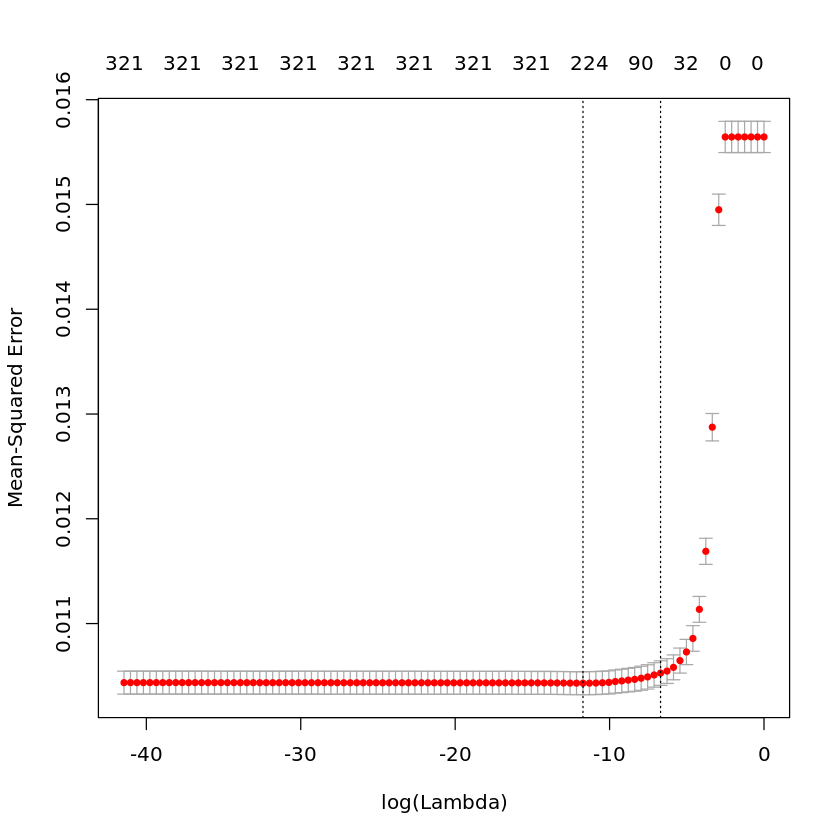

In [6]:
set.seed(0)
#X==predictor
#y==response

y <- ATAC_val %>% as.matrix()
X <- all_samples_gaussian_trimmed_controls %>% as.matrix()

lambdas_to_try <- 10^seq(-18, 0, length.out = 100)
#standardize = FALSE -- range -12, -3
#standardize = TRUE -- range -10, 0


lasso_smooth_cv <- cv.glmnet(X, y, alpha = 1, lambda = lambdas_to_try,
                      standardize = TRUE, nfolds = 10)

#Plotting the MSE and log(lambda)

plot(lasso_smooth_cv)

In [7]:
(lambda_smooth_cv <- lasso_smooth_cv$lambda.min)

[1] 8.111308e-06

In [13]:
CV_lasso_smooth<-function(data, nfolds){
    set.seed(0)
    cvfolds <- cut(1:nrow(data), breaks = nfolds, labels = F)
    cvfolds <- sample(cvfolds)
    
    predicted <- rep(NA, nrow(data))
    #data_as_matrix <- data %>% dplyr::select(-ATAC_val) %>% as.matrix() 
    
    y <- ATAC_val %>%  as.matrix()
    X <- all_samples_gaussian_trimmed_controls %>% as.matrix()
    
    for (i in 1:nfolds){
        rows      <- which(cvfolds==i)
        testdata  <- X[rows,]
        traindata <- X[-rows,]
        train_y <- y[-rows,]

        fit       <- glmnet(traindata, train_y, alpha = 1, lambda = lambda_smooth_cv, standardize = TRUE)
        tmp       <- predict(fit, s=lambda_smooth_cv, testdata)
        predicted[rows] <- tmp
    }
    
    rm(tmp)
    observed <- y
    head(observed)
    mean(observed)
    se    <- (observed-predicted)^2
    mse   <- mean(se)
    (rmse <- sqrt(mse))
    
    return(tibble(observed = observed, predicted = predicted))
}

In [14]:
(res_lasso_gaussian_smooth_trimmed_pred_controls <- CV_lasso_smooth(all_samples_gaussian_trimmed_controls, 10))

observed,predicted
0.5866651,0.4759513
0.1996134,0.3581158
0.5968816,0.4693344
0.2905764,0.3460725
0.2319729,0.3754008
0.2262170,0.3943270
0.3546569,0.4061454
0.4456518,0.4621853
0.4719340,0.4764195
0.4991555,0.4518052


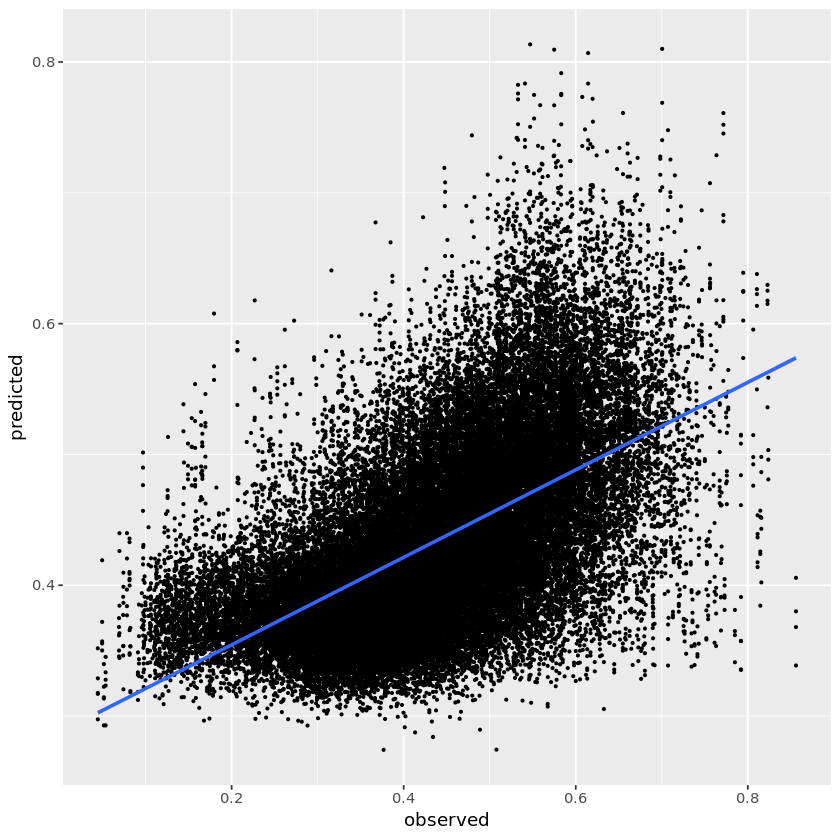

In [15]:
ggplot(res_lasso_gaussian_smooth_trimmed_pred_controls, aes(x = observed, y = predicted)) + 
    geom_point(size = 0.5) + 
    geom_smooth(method = "lm", formula = y~x)

In [17]:
cor(res_lasso_gaussian_smooth_trimmed_pred_controls$observed, res_lasso_gaussian_smooth_trimmed_pred_controls$predicted)

# Standardize = TRUE: ATAC_val 0.6929081
# Standardize = FALSE: ATAC_val 

ATAC_observed,0.5770947


## Save the predictions made with CV on controls to file

In [ ]:
res_lasso_gaussian_smooth_trimmed_pred_controls <- controls_predictions %>% mutate(ATAC_observed = res_lasso_gaussian_smooth_trimmed_pred_controls$observed, 
                                                                                   ATAC_predicted = res_lasso_gaussian_smooth_trimmed_pred_controls$predicted)

head(res_lasso_gaussian_smooth_trimmed_pred_controls)

In [ ]:
write.table(res_lasso_gaussian_smooth_trimmed_pred_controls, snakemake@output[["output_pred"]], append = F, sep=',', col.names=T, row.names=F)

## Fit the model on all controls

In [10]:
y <- ATAC_val %>% as.matrix()
X <- all_samples_gaussian_trimmed_controls %>% as.matrix()

fit       <- glmnet(X, y, alpha = 1, lambda = lambda_smooth_cv, standardize = TRUE)
# saving the model
saveRDS(fit, snakemake@output[["output_model"]])

#tmp       <- predict(fit, s=lambda_smooth_cv, testdata)

## Predict on normalized, smoothed and trimmed cases using the model (fitted on all controls) and add the predictions to the file

In [11]:
#filename = "../../../data/all_samples_normalized_gaussian_smooth_trimmed_CASES.csv"
filename = snakemake@input[["input_test_data_trim"]]

In [12]:
small_test <- read_csv(file = filename, col_names = T, comment = "#", skip = 0, n_max = 20)
head(small_test)

Parsed with column specification:
cols(
  .default = col_double(),
  sample = col_character(),
  bin = col_character()
)
See spec(...) for full column specifications.


sample,bin,X80,X81,X82,X83,X84,X85,X86,X87,...,X391,X392,X393,X394,X395,X396,X397,X398,X399,X400
PGDX10344P1,chr10_400,0,0.0000000000,0.0000000000,0.0000000000,0,0.0002261932,0.0002261932,0.0000000000,...,0.0002261932,0.0004523863,0.0000000000,0.0002261932,0.0000000000,0.0002261932,0.0000000000,0.0000000000,0.0000000000,0.0002261932
PGDX10344P1,chr10_40,0,0.0000000000,0.0000000000,0.0000000000,0,0.0000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,0.0002773925,0.0002773925,0.0002773925,0.0002773925,0.0000000000,0.0002773925,0.0002773925,0.0002773925
PGDX10344P1,chr10_4,0,0.0000000000,0.0002667378,0.0000000000,0,0.0000000000,0.0002667378,0.0000000000,...,0.0002667378,0.0005334756,0.0002667378,0.0002667378,0.0000000000,0.0005334756,0.0000000000,0.0000000000,0.0000000000,0.0000000000
PGDX10344P1,chr10_401,0,0.0000000000,0.0000000000,0.0002428363,0,0.0002428363,0.0000000000,0.0002428363,...,0.0002428363,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0007285090,0.0004856727,0.0000000000
PGDX10344P1,chr10_402,0,0.0000000000,0.0000000000,0.0002801905,0,0.0000000000,0.0002801905,0.0000000000,...,0.0002801905,0.0002801905,0.0002801905,0.0005603811,0.0002801905,0.0000000000,0.0002801905,0.0002801905,0.0005603811,0.0002801905
PGDX10344P1,chr10_403,0,0.0005206977,0.0000000000,0.0000000000,0,0.0002603489,0.0000000000,0.0000000000,...,0.0002603489,0.0000000000,0.0000000000,0.0005206977,0.0000000000,0.0002603489,0.0002603489,0.0002603489,0.0002603489,0.0005206977


In [15]:
f <- function(df1, pos) {
    df1[3:323] <- lapply(df1[3:323], as.numeric)
    
    df <- df1 %>% select(-c("sample", "bin")) %>% as.matrix()
    tmp       <- as.vector(predict(fit, s=lambda_smooth_cv, df))
    
    pred_tibble <- tibble(sample = df1$sample, bin = df1$bin)
    rm(df)
    rm(df1)
    pred_tibble <- inner_join(pred_tibble, ATAC, by="bin")
    pred_tibble <- pred_tibble %>% mutate(ATAC_predicted = tmp)
    
    rm(tmp)
    #message(pred_tibble)
    write.table(pred_tibble, snakemake@output[["output_pred"]], append = TRUE, sep=',', col.names=F, row.names=F)
}

df <- read_delim_chunked(file = filename, 
                 callback = DataFrameCallback$new(f), 
                 chunk_size = 10000, col_names = T,
                 delim = ",", 
                 progress = show_progress())

Parsed with column specification:
cols(
  .default = col_double(),
  sample = col_character(),
  bin = col_character()
)
See spec(...) for full column specifications.
